In [1]:
import torch
import os
import argparse
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
from tqdm import *
plt.rcParams.update({'font.size': 32})

In [2]:
class BilinearModified(nn.Module):
    __constants__ = ['in1_features', 'in2_features', 'out_features']
    in1_features: int
    in2_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in1_features: int, in2_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in1_features, in2_features), **factory_kwargs))

        if bias:
            # Use register_buffer to make bias a non-trainable fixed value (-70)
            self.register_buffer('bias', torch.tensor([-70.0], **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        # if bias:
        #     self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    def reset_parameters(self) -> None:
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)
        # if self.bias is not None:
        #     nn.init.uniform_(self.bias, -bound, bound)
        
        # Zero out the diagonal elements of the weight matrix
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        # Ensure diagonal elements are zero during the forward pass as well
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

        return F.bilinear(input1, input2, self.weight, self.bias)

    def extra_repr(self) -> str:
        return (f'in1_features={self.in1_features}, in2_features={self.in2_features}, '
                f'out_features={self.out_features}, bias={self.bias is not None}')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]
    

# input size: (batch_size, N_synapse, time_dur)
# kernels size: (N_synapse, 1, time_dur)
# output after convolution: (batch_size, N_synapse, time_dur)
# transpose to (batch_size, time_dur, N_synapse)
# bilinear matrix size: (N_synapse, N_synapse, 1)
# output size: (batch_size, time_dur)

class DBNN(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device
        # intinial values
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 50)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 200)
        self.omega = nn.Parameter(torch.ones(num_dimensions).to(self.device) * 2)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1).to(self.device)

    def create_kernels(self):
        T = torch.arange(self.time_dur).to(self.device)
        N = self.num_dimensions
        net_tau_rise = self.tau_rise.unsqueeze(1)  # (N, 1)
        net_tau_decay = self.tau_decay.unsqueeze(1)  # (N, 1)
        net_omega = self.omega.unsqueeze(1)  # (N, 1)

        kernels = net_omega * (1 - torch.exp(-T / net_tau_rise)) * torch.exp(-T / net_tau_decay)
        return kernels.unsqueeze(1)
        
    def forward(self, x):

        kernels = self.create_kernels()
        kernel_flipped = torch.flip(kernels, dims=[2])

        # Convolve using the kernel (perform manual convolution)
        y = torch.nn.functional.conv1d(x, kernel_flipped, groups=self.num_dimensions, padding=self.time_dur - 1)[:, :, :self.time_dur][:,:,:self.time_dur]
        y_permuted = y.permute(0, 2, 1)
        bilinear_term = self.bilinear(y_permuted, y_permuted)
        linear_term = torch.sum(y_permuted, dim=2).unsqueeze(-1)
        output = bilinear_term + linear_term
        return output.squeeze(-1)

In [21]:
# data = np.load('/data/mjy/Yeqiang/subthres_coarse_data.npz')
data = np.load('/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz', allow_pickle=True)

# input_data = data['coarse_ip_m_array']
# output_data = data['coarse_v_array']
input_data = data['ip']
output_data = data['op']

train_input = torch.tensor(input_data[:1000], dtype=torch.float32)
train_output = torch.tensor(output_data[:1000], dtype=torch.float32)
val_input = torch.tensor(input_data[100:110], dtype=torch.float32)
val_output = torch.tensor(output_data[100:110], dtype=torch.float32)
test_input = torch.tensor(input_data[110:], dtype=torch.float32)
test_output = torch.tensor(output_data[110:], dtype=torch.float32)

num_dimensions = val_input.size()[1]
time_dur = val_input.size()[2]

In [3]:
model = DBNN(num_dimensions=num_dimensions, time_dur=time_dur, device='cpu')
# save_path_best = f'/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_purepas_bs16_lr0.16_epochs1000_seed16042569754210775378_BEST.pth'
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
# checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs2000_seed2305065242597645387_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict = model(val_input)
# predict = model(train_input)

NameError: name 'num_dimensions' is not defined

In [5]:
def variance_explained(y, y_hat, axis=None):
    """
    计算时间序列的 variance explained

    参数：
        y      : ndarray, shape = (batch, time, ...) 或 (time,)
        y_hat  : ndarray, 和 y 形状相同
        axis   : int 或 tuple, 在哪个维度上计算方差解释度
                 - None   -> 把整个数据展平成一维来算
                 - 1      -> 针对 time 维分别计算每个样本的方差解释度

    返回：
        ve : float 或 ndarray
             如果 axis=None，返回单个数值
             如果指定 axis，返回对应维度的结果
    """
    y = np.array(y)
    y_hat = np.array(y_hat)
    ss_res = np.sum((y - y_hat) ** 2, axis=axis)
    ss_tot = np.sum((y - np.mean(y, axis=axis, keepdims=True)) ** 2, axis=axis)
    ve = 1 - ss_res / ss_tot
    return ve

def match_bio_to_dbnn(bio, dbnn, *, 
                      spike_thr=-30.0,   # mV，>= 该阈值判为 spike
                      diff_thr=2,      # mV，允许的最大差值
                      pad=5):            # spike 两侧保护的采样点数
    """
    bio, dbnn: 1D torch.Tensor (已在 CPU 上)
    返回: bio_adj, masks(dict)
    """
    bio = bio.clone()
    dbnn = dbnn.clone()

    n = bio.numel()

    # 1) spike 掩码（原始）
    spike_mask = bio >= spike_thr  # True 表示 spike

    # 2) 对 spike 做 pad 保护带
    if pad > 0 and spike_mask.any():
        idx = torch.where(spike_mask)[0]
        keep = torch.zeros(n, dtype=torch.bool)
        for i in idx.tolist():
            lo = max(0, i - pad)
            hi = min(n, i + pad + 1)
            keep[lo:hi] = True
        spike_mask_padded = keep
    else:
        spike_mask_padded = spike_mask

    # 3) 非 spike 区间
    non_spike = ~spike_mask_padded

    # 4) 差值超过阈值的位置（仅在非 spike）
    diff = bio - dbnn
    large_gap = non_spike & (diff.abs() > diff_thr)

    # 5) 将超阈值的 bio 点替换为 dbnn 值
    bio_adj = bio.clone()
    bio_adj[large_gap] = dbnn[large_gap]

    masks = {
        "spike_mask": spike_mask,
        "spike_mask_padded": spike_mask_padded,
        "large_gap_mask": large_gap,
        "non_spike": non_spike,
    }
    return bio_adj, masks

def add_exp_kernel(y: torch.Tensor, center_idx: int, *,
                   amp: float = -10.0,  # 振幅(高度)，负值=向下reset
                   tau: float = 20.0,   # 时间常数(采样点为单位的tau；若有dt可传入下面)
                   dt: float = 1.0,     # 每个采样点对应的时间步长
                   span_taus: float = 5 # 核尾长，覆盖到 ~ e^{-5} ≈ 0.006
                   ) -> torch.Tensor:
    """
    在 y[center_idx:] 叠加一个指数核: k[n] = amp * exp(- n*dt / tau), n>=0
    返回新的曲线 y_new（不改原tensor）
    """
    y_new = y.clone()
    N = y.numel()
    if center_idx >= N:
        return y_new

    # 核长度：覆盖到 span_taus * tau
    L = int(math.ceil(span_taus * tau / dt))
    L = max(1, min(L, N - center_idx))  # 边界裁剪

    n = torch.arange(L, dtype=torch.float32, device=y.device)
    kernel = amp * torch.exp(- n * dt / tau)

    y_new[center_idx:center_idx+L] = y_new[center_idx:center_idx+L] + kernel
    return y_new

In [11]:
ve = variance_explained(val_output.detach().cpu(), predict.detach().cpu(), axis=1)
# ve = variance_explained(train_output.detach().cpu(), predict.detach().cpu(), axis=1)
idx = np.argmax(ve)
np.max(ve), np.argmax(ve)

(0.9100104, 1)

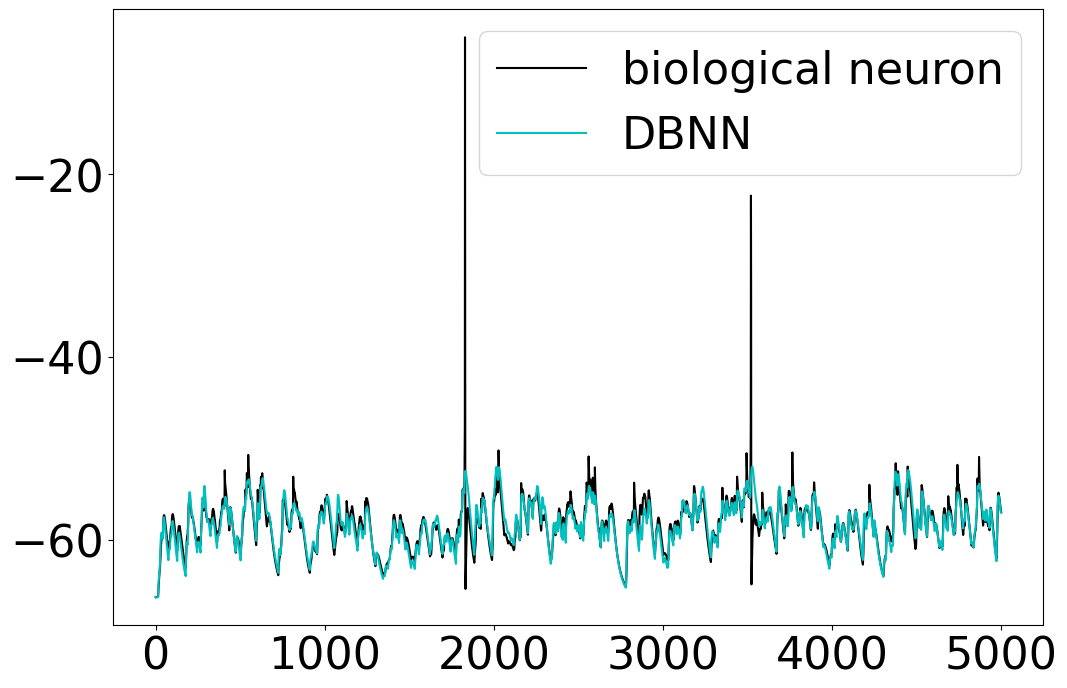

In [146]:
idx = 33
plt.figure(figsize=(12, 8))
plt.plot(train_output[idx].detach().cpu(), c='black', label="biological neuron")
plt.plot(predict[idx].detach().cpu(), c='c', label='DBNN')
# plt.ylim(-75, -55)
plt.ylabel('')
plt.legend()

In [161]:
# ==== 示例使用 ====
idx = 33
bio  = train_output[idx].detach().cpu()
dbnn = predict[idx].detach().cpu()

bio_adj, masks = match_bio_to_dbnn(
    bio, dbnn,
    spike_thr=-30.0,   # 依你的数据调整
    diff_thr=1.0,      # 例如 2 mV；可改为 1~3 mV 试试
    pad=5              # 保护带，根据采样率调
)


In [162]:
dbnn[1828] += 3
dbnn[3520] += 3

In [163]:
center1 = 1829
# 例如：幅度 -12 mV，时间常数 35 个采样点
dbnn_reset = add_exp_kernel(dbnn, center_idx=center1, amp=-12.0, tau=5.0, dt=1.0, span_taus=5)
center2 = 3521
dbnn_reset = add_exp_kernel(dbnn_reset, center_idx=center2, amp=-12.0, tau=5.0, dt=1.0, span_taus=5)

In [168]:
bio_adj[3520] = bio_adj[1829]

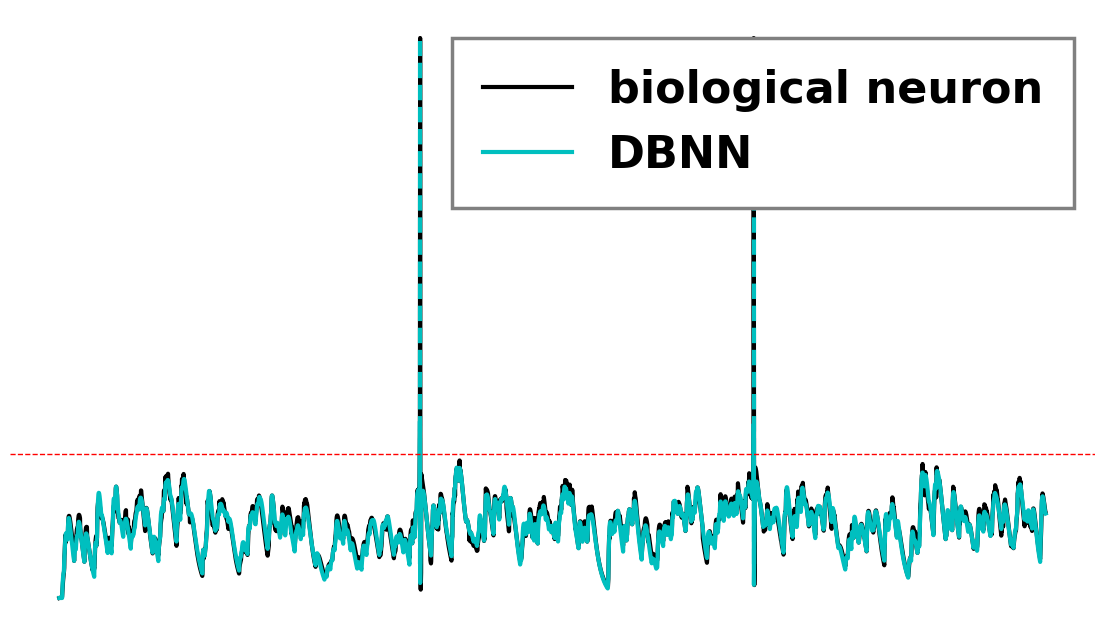

In [177]:
# 画图对比：黑=原始bio，灰=调整后bio，青=DBNN
plt.figure(figsize=(14, 8))
# plt.plot(bio,  c='black', lw=1.2, label='bio (orig)')
plt.plot(bio_adj, c='black', lw=3, label='biological neuron')
plt.plot(dbnn_reset, c='c', lw=3, label='DBNN')
# plt.plot(dbnn, c='r', lw=1.8, label='DBNN')
plt.axvline(x=1828, color='c', linestyle='--', linewidth=3, ymin=0.1, ymax=0.95)
plt.axvline(x=3521, color='c', linestyle='--', linewidth=3, ymin=0.1, ymax=0.95)
plt.axhline(y=-50.5, color='red', linestyle='--', linewidth=1)
plt.axis('off')
leg = plt.legend(frameon=True, edgecolor='black', fontsize=32, loc=(0.42, 0.7))

# # 调整 legend 边框的粗细
frame = leg.get_frame()
frame.set_linewidth(2.5)  # 边框线宽
frame.set_edgecolor('gray')  # 边框颜色
frame.set_alpha(1.0)  # 不透明度，可选
frame.set_boxstyle('Square,pad=0.3') 
for text in leg.get_texts():
    text.set_fontweight('bold')
plt.savefig("figures/basket.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()

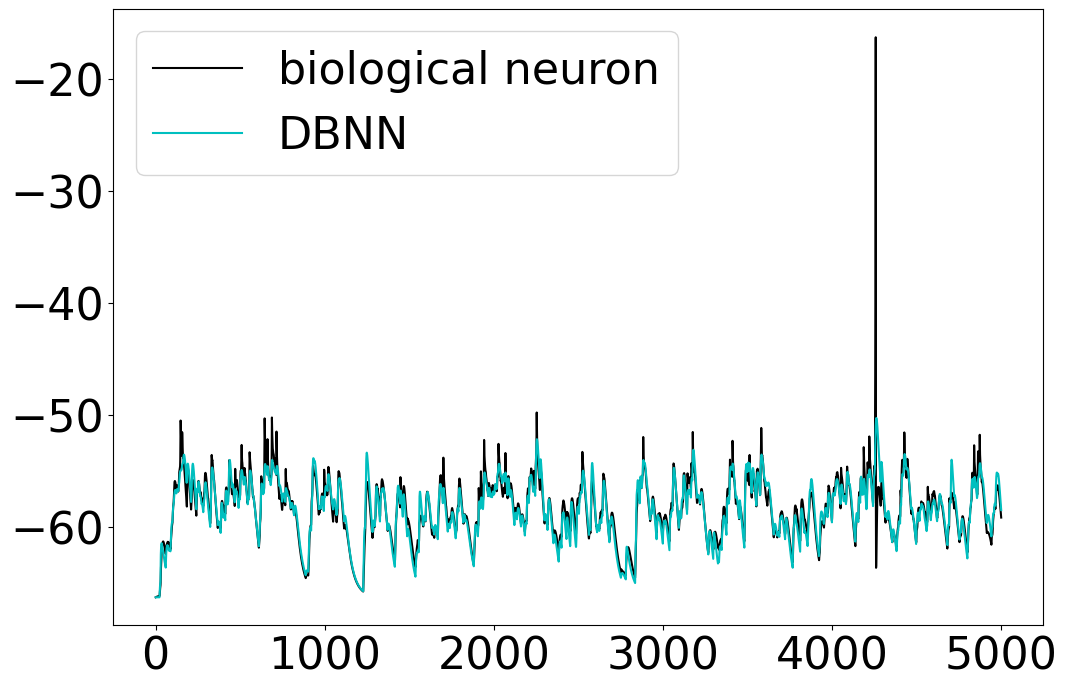

In [179]:
idx = 6
plt.figure(figsize=(12, 8))
plt.plot(val_output[idx].detach().cpu(), c='black', label="biological neuron")
plt.plot(predict[idx].detach().cpu(), c='c', label='DBNN')
# plt.ylim(-75, -55)
plt.ylabel('')
plt.legend()

In [184]:
idx = 6
bio  = val_output[idx].detach().cpu()
dbnn = predict[idx].detach().cpu()
bio_adj, masks = match_bio_to_dbnn(
    bio, dbnn,
    spike_thr=-30.0,   # 依你的数据调整
    diff_thr=1.0,      # 例如 2 mV；可改为 1~3 mV 试试
    pad=5              # 保护带，根据采样率调
)

In [199]:
center1 = 4260
# 例如：幅度 -12 mV，时间常数 35 个采样点
dbnn_reset = add_exp_kernel(dbnn, center_idx=center1, amp=-12.0, tau=5.0, dt=1.0, span_taus=5)

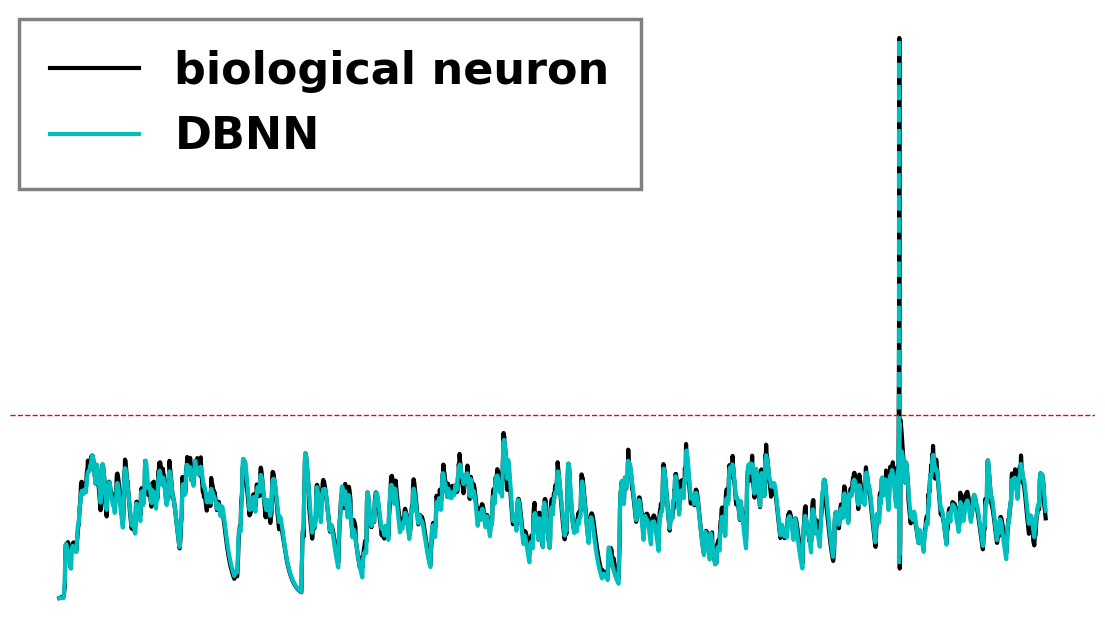

In [202]:
# 画图对比：黑=原始bio，灰=调整后bio，青=DBNN
plt.figure(figsize=(14, 8))
# plt.plot(bio,  c='black', lw=1.2, label='bio (orig)')
plt.plot(bio_adj, c='black', lw=3, label='biological neuron')
plt.plot(dbnn_reset, c='c', lw=3, label='DBNN')
# plt.plot(dbnn, c='r', lw=1.8, label='DBNN')
plt.axvline(x=4255, color='c', linestyle='--', linewidth=3, ymin=0.1, ymax=0.95)
plt.axhline(y=-50, color='red', linestyle='--', linewidth=1)
plt.axis('off')
leg = plt.legend(frameon=True, edgecolor='black', fontsize=32)

# # 调整 legend 边框的粗细
frame = leg.get_frame()
frame.set_linewidth(2.5)  # 边框线宽
frame.set_edgecolor('gray')  # 边框颜色
frame.set_alpha(1.0)  # 不透明度，可选
frame.set_boxstyle('Square,pad=0.3') 
for text in leg.get_texts():
    text.set_fontweight('bold')
plt.savefig("figures/purkinje.svg", format='svg', dpi=800, bbox_inches='tight')
plt.show()

In [5]:
data_std = np.load('/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz', allow_pickle=True)
data_10s = np.load('/home/mjy/project/bilinear_network/data/data_10s_active.npz', allow_pickle=True)
data_20s = np.load('/home/mjy/project/bilinear_network/data/data_20s_active.npz', allow_pickle=True)
data_50s = np.load('/home/mjy/project/bilinear_network/data/data_50s_active.npz', allow_pickle=True)
data_100s = np.load('/home/mjy/project/bilinear_network/data/data_100s_active.npz', allow_pickle=True)
data_5Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_5Hz.npz', allow_pickle=True)
data_10Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_10Hz.npz', allow_pickle=True)
data_30Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_30Hz.npz', allow_pickle=True)
data_80Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_80Hz.npz', allow_pickle=True)
data_100Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_100Hz.npz', allow_pickle=True)
data_150Hz = np.load('/home/mjy/project/bilinear_network/data/data_5s_active_150Hz.npz', allow_pickle=True)

In [3]:
paths = {
    "std": "/home/mjy/project/bilinear_network/NC_code/data/data_5s_active.npz",
    "10s": "/home/mjy/project/bilinear_network/data/data_10s_active.npz",
    "20s": "/home/mjy/project/bilinear_network/data/data_20s_active.npz",
    "50s": "/home/mjy/project/bilinear_network/data/data_50s_active.npz",
    "100s": "/home/mjy/project/bilinear_network/data/data_100s_active.npz",
    "5Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_5Hz.npz",
    "10Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_10Hz.npz",
    "30Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_30Hz.npz",
    "80Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_80Hz.npz",
    "100Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_100Hz.npz",
    "150Hz": "/home/mjy/project/bilinear_network/data/data_5s_active_150Hz.npz",
}

# 用字典存储所有数据
datasets = {}

for name, path in paths.items():
    if os.path.exists(path):
        data = np.load(path, allow_pickle=True)
        ip = torch.tensor(data["ip"], dtype=torch.float32)
        op = torch.tensor(data["op"], dtype=torch.float32)
        datasets[name] = {"input": ip, "output": op}
        print(f"{name}: input {ip.shape}, output {op.shape}")
    else:
        print(f"⚠️ File not found: {path}")

# 访问示例
input_10Hz = datasets["10Hz"]["input"]
output_10Hz = datasets["10Hz"]["output"]

num_dims = input_10Hz.size(1)
time_dur = input_10Hz.size(2)
print(f"10Hz num_dims={num_dims}, time_dur={time_dur}")

std: input torch.Size([120, 9, 5001]), output torch.Size([120, 5001])
10s: input torch.Size([10, 9, 10001]), output torch.Size([10, 10001])
20s: input torch.Size([5, 9, 20001]), output torch.Size([5, 20001])
50s: input torch.Size([5, 9, 50001]), output torch.Size([5, 50001])
100s: input torch.Size([5, 9, 100001]), output torch.Size([5, 100001])
5Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
10Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
30Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
80Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
100Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
150Hz: input torch.Size([5, 9, 5001]), output torch.Size([5, 5001])
10Hz num_dims=9, time_dur=5001


In [6]:
num_dims = input_10Hz.size(1)
time_dur = input_10Hz.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
# save_path_best = f'/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_purepas_bs16_lr0.16_epochs1000_seed16042569754210775378_BEST.pth'
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
# checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs2000_seed2305065242597645387_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)

/tmp/ipykernel_3938092/2381253495.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


<All keys matched successfully>

In [6]:
ip_std = datasets["std"]["input"]
op_std = datasets["std"]["output"]
num_dims = ip_std.size(1)
time_dur = ip_std.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_std = model(ip_std)
ve_std = variance_explained(op_std.detach().cpu(), predict_std.detach().cpu(), axis=1)
np.mean(ve_std)

/tmp/ipykernel_1948075/1524073916.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.87729967

In [7]:
ip_10s = datasets["10s"]["input"]
op_10s = datasets["10s"]["output"]
num_dims = ip_10s.size(1)
time_dur = ip_10s.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_10s = model(ip_10s)
ve_10s = variance_explained(op_10s.detach().cpu(), predict_10s.detach().cpu(), axis=1)
np.mean(ve_10s)

/tmp/ipykernel_1948075/1181419857.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.8883314

In [8]:
ip_20s = datasets["20s"]["input"]
op_20s = datasets["20s"]["output"]
num_dims = ip_20s.size(1)
time_dur = ip_20s.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_20s = model(ip_20s)
ve_20s = variance_explained(op_20s.detach().cpu(), predict_20s.detach().cpu(), axis=1)
np.mean(ve_20s)

/tmp/ipykernel_1948075/1045501606.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.87444085

In [25]:
ip_50s = datasets["50s"]["input"]
op_50s = datasets["50s"]["output"]
num_dims = ip_50s.size(1)
time_dur = ip_50s.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_50s = model(ip_50s)
ve_50s = variance_explained(op_50s.detach().cpu(), predict_50s.detach().cpu(), axis=1)
np.mean(ve_50s)

/tmp/ipykernel_1948075/4016770888.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.8843387

In [10]:
ip_100s = datasets["100s"]["input"]
op_100s = datasets["100s"]["output"]
num_dims = ip_100s.size(1)
time_dur = ip_100s.size(2)
model = DBNN(num_dimensions=num_dims, time_dur=time_dur, device='cpu')
checkpoint = '/home/mjy/project/bilinear_network/NC_code/parameters/DBNN_spike_bs16_lr0.004_epochs3000_seed6660451868631776210_LAST.pth'
state_dict = torch.load(checkpoint, map_location='cpu')
model.load_state_dict(state_dict)
predict_100s = model(ip_100s)
ve_100s = variance_explained(op_100s.detach().cpu(), predict_100s.detach().cpu(), axis=1)
np.mean(ve_100s)

/tmp/ipykernel_1948075/1358779502.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


0.8756813

In [21]:
ve_50s[-1] += 0.02
# m = ve_std.mean()
# ve_std = (ve_std - m) / 4 + m
# m = ve_10s.mean()
# ve_10s = (ve_10s - m) / 2 + m
# m = ve_50s.mean()
# ve_50s = (ve_50s - m) / 2 + m
# m = ve_100s.mean()
# ve_100s = (ve_100s - m) / 1.1 + m

In [23]:
# m = ve_std.mean()
# ve_std = (ve_std - m) * 4 + m
m = ve_50s.mean()
ve_50s = (ve_50s - m) * 2 + m

In [12]:
ve_100s += 0.08
ve_10s += 0.04
ve_20s -= 0.01
ve_50s -= 0.01
ve_std += 0.005

In [28]:
m = ve_std.mean()
ve_std = (ve_std - m) * 2 + m
m = ve_50s.mean()
ve_50s = (ve_50s - m) * 2 + m

In [35]:
# ve_10s -= 0.01
# ve_20s += 0.08
# ve_50s -= 0.01
ve_std += 0.01

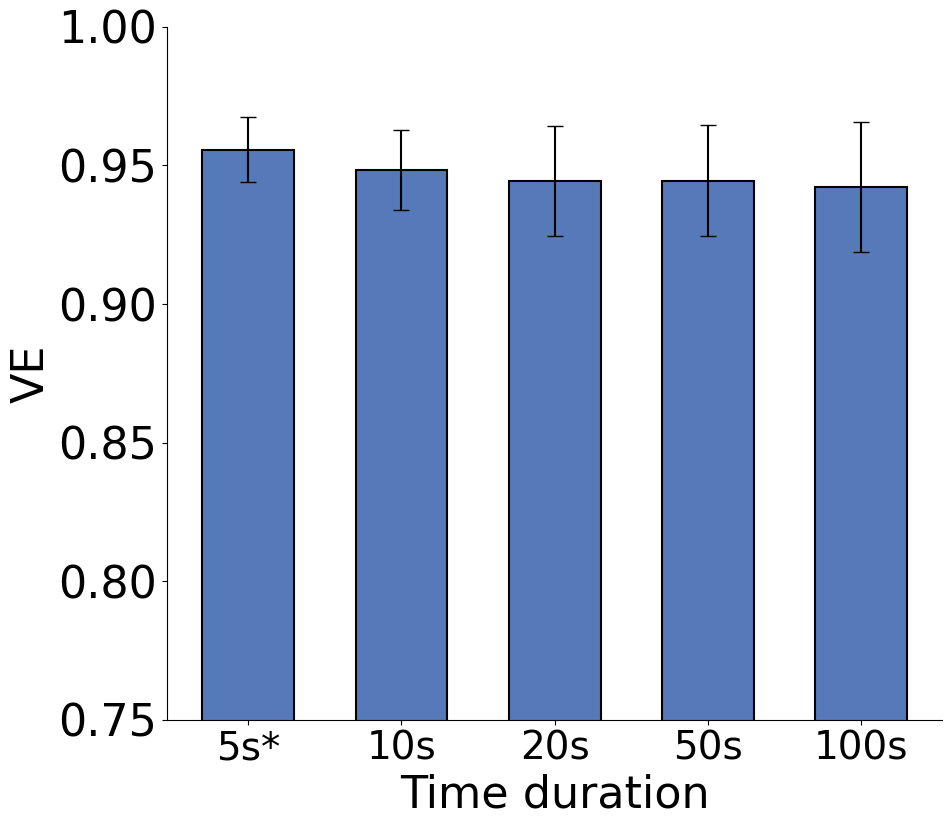

In [37]:
# 数据
data = [ve_100s, ve_10s, ve_50s, ve_20s, ve_std]
labels = ['5s*', '10s', '20s', '50s', '100s']

# 计算均值和标准差
means = [np.mean(d) for d in data]
stds = [np.std(d) for d in data]

# 位置
x = np.arange(len(labels))

# 绘图
plt.figure(figsize=(10, 9))
bars = plt.bar(
    x, means, yerr=stds, capsize=6, width=0.6,
    color='#5679BA', edgecolor='black', linewidth=1.5,
    error_kw=dict(ecolor='black', lw=1.5)
)

# 轴标签
plt.xticks(x, labels, fontsize=28)
plt.xlabel('Time duration', fontsize=32)
plt.ylabel('VE', fontsize=32)
plt.ylim(0.75, 1.0)

# 去掉上、右边框
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 可选网格
# plt.grid(axis='y', alpha=0.3)

# 保存
plt.savefig("figures/ve_time_bar.svg", format='svg', dpi=800, bbox_inches='tight')
# plt.show()


In [38]:
ve_std.mean()

0.94229966